# Modeling Heisman Candidates
***Sean Steinle***


In this notebook we'll synthesize our data into one file and model our candidates.

## Table of Contents

1. [Remaining Data Cleaning](#1)
2. [Modeling and Machine Learning](#2)
    1. [Unsupervised Learning](#2a)
    2. [Linear Regression](#2b)
    3. [Neural Network](#2c)

<a id='1'></a>

## Remaining Data Cleaning

In this section, we'll be reorganizing our data one more time before we finally perform inferential statistics.

In [1]:
#import libraries
import cfbd
import pandas as pd
import time
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df_qb = pd.read_csv("../data/heisman_QBs.csv")
df_rb = pd.read_csv("../data/heisman_RBs.csv")
df_wr = pd.read_csv("../data/heisman_WRs.csv")
df_rb["POS"] = "RB"
df_wr["POS"] = "WR"

In [3]:
#Only run one time: will paste over manual edits!
#This code creates numeric variables for class, school, and position (position for RB and WR)
df_rbwr = pd.concat([df_rb,df_wr],axis=0)
df_rbwr["ClassNum"] = pd.factorize(df_rbwr["Class"])[0]
df_rbwr["SchoolNum"] = pd.factorize(df_rbwr["School"])[0]
df_rbwr["POSNum"] = pd.factorize(df_rbwr["POS"])[0]

df_qb["ClassNum"] = pd.factorize(df_qb["Class"])[0]
df_qb["SchoolNum"] = pd.factorize(df_qb["School"])[0]
#df_rbwr.to_csv("../data/Heisman_RBWRs_.csv")
#df_qb.to_csv("../data/Heisman_QBs_.csv")

At this point, I'll do a few edits to remove superfluous columns and to format the .csv better.

In [4]:
df_rbwr = pd.read_csv("../data/Heisman_RBWRs.csv")
df_qb = pd.read_csv("../data/Heisman_QBs.csv")

In [5]:
#create a DF with all numeric attributes for modeling. found non-numerics to drop with df_qb.dtypes
#drop School, Class, POS (for rbwr)
df_qb_num = df_qb.drop(columns=['School','Class'])
df_rbwr_num = df_rbwr.drop(columns=['School','Class','POS'])

<a id='2a'></a>

## Unsupervised Learning

In this section we will conduct k-means clustering on our dataframes to see if we can predict Heisman winners from their dimensions alone, without using the vote share labels we will use in supervised learning. After clustering, we will reduce our data two two dimensions using PCA, a dimensionality reduction technique.

In [6]:
#here we create an instance of our clustering algorithm to create 3 clusters in each of our datasets
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
df_qb_num['Cluster'] = kmeans.fit_predict(df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare']))
df_rbwr_num['Cluster'] = kmeans.fit_predict(df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare']))

#here, we're using PCA (principal component analysis) to reduce the values of our data attributes down to only two dimensions for
#the purpose of visualizing all of the different attributes together
pca = sklearn.decomposition.PCA(n_components=2)
trans_df = pd.DataFrame(pca.fit_transform(df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare'])), columns=['X','Y'])
df_qb_num["X"] = trans_df["X"]
df_qb_num["Y"] = trans_df["Y"]

trans_df = pd.DataFrame(pca.fit_transform(df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare'])), columns=['X','Y'])
df_rbwr_num["X"] = trans_df["X"]
df_rbwr_num["Y"] = trans_df["Y"]

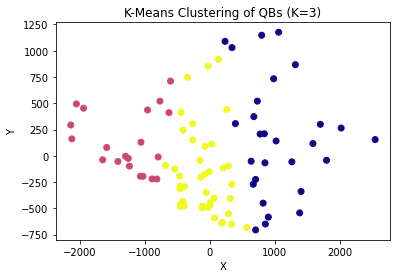

In [23]:
plt.scatter(df_qb_num["X"],df_qb_num["Y"],c=df_qb_num["Cluster"],cmap='plasma')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("K-Means Clustering of QBs (K=3)")
plt.savefig("../plots/kmeans_qb.jpg")

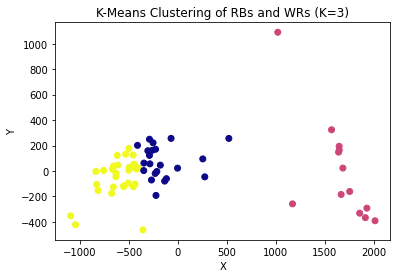

In [28]:
plt.scatter(df_rbwr_num["X"],df_rbwr_num["Y"],c=df_rbwr_num["Cluster"],cmap='plasma')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("K-Means Clustering of RBs and WRs (K=3)")
plt.savefig("../plots/kmeans_rbwr.jpg")

In [22]:
qb_clusters = df_qb_num.groupby(['Cluster'])
print(qb_clusters['1stVoteShare'].mean())
print(qb_clusters['TotalPointShare'].mean())
print(qb_clusters['X'].mean())
print(qb_clusters['Y'].mean())
#for name,group in qb_clusters:
#    print(name,group)

Cluster
0    0.133983
1    0.238170
2    0.092839
Name: 1stVoteShare, dtype: float64
Cluster
0    0.115479
1    0.183809
2    0.108091
Name: TotalPointShare, dtype: float64
Cluster
0    1039.408890
1   -1263.421665
2     -93.536967
Name: X, dtype: float64
Cluster
0    165.751402
1    130.980069
2   -177.088796
Name: Y, dtype: float64


In [10]:
rbwr_clusters = df_rbwr_num.groupby(['Cluster'])
print(rbwr_clusters['1stVoteShare'].mean())
print(rbwr_clusters['TotalPointShare'].mean())
print(qb_clusters['X'].mean())
print(qb_clusters['Y'].mean())
#for name,group in rbwr_clusters:
#    print(name,group)

Cluster
0    0.073171
1    0.046469
2    0.060535
Name: 1stVoteShare, dtype: float64
Cluster
0    0.077702
1    0.054977
2    0.081521
Name: TotalPointShare, dtype: float64
Cluster
0    1039.408890
1   -1263.421665
2     -93.536967
Name: X, dtype: float64
Cluster
0    165.751402
1    130.980069
2   -177.088796
Name: Y, dtype: float64


**Conclusion**

We saw promising results in that there was at least some discrimination of vote share between clusters. I'm skeptical that this is a sound mechanism for classifying promising candidates generally, but it is interesting nonetheless.

<a id='2b'></a>

## Linear Regression

In [11]:
Xqb = df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yqb = df_qb_num['1stVoteShare']
Xrbwr = df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yrbwr = df_rbwr_num['1stVoteShare']

In [12]:
Xqb_train, Xqb_test, Yqb_train, Yqb_test = train_test_split(Xqb, Yqb, test_size=0.2)
Xrbwr_train, Xrbwr_test, Yrbwr_train, Yrbwr_test = train_test_split(Xrbwr, Yrbwr, test_size=0.2)

In [13]:
lr_qb = LinearRegression()
lr_qb.fit(Xqb_train,Yqb_train)
print(lr_qb.score(Xqb_test,Yqb_test))

lr_rbwr = LinearRegression()
lr_rbwr.fit(Xrbwr_train,Yrbwr_train)
print(lr_rbwr.score(Xrbwr_test,Yrbwr_test))

-0.04125932514471309
-0.1934290029972967


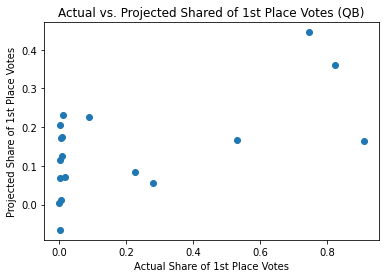

In [29]:
preds = lr_qb.predict(Xqb_test)
plt.scatter(Yqb_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes (QB)")
plt.savefig("../plots/lr_qb.jpg")

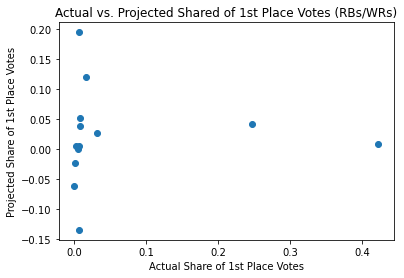

In [25]:
preds = lr_rbwr.predict(Xrbwr_test)
plt.scatter(Yrbwr_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes (RBs/WRs)")
plt.savefig("../plots/lr_rbwr.jpg")

**Conclusion**

The response is a bit imbalanced so linear regression may not be the right tool here. Additionally, our R-squared values are not very good.

<a id='2c'></a>
## Neural Networks



In [16]:
Xqb = df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yqb = df_qb_num['1stVoteShare']
Xrbwr = df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yrbwr = df_rbwr_num['1stVoteShare']

In [17]:
Xqb_train, Xqb_test, Yqb_train, Yqb_test = train_test_split(Xqb, Yqb, test_size=0.2)
Xrbwr_train, Xrbwr_test, Yrbwr_train, Yrbwr_test = train_test_split(Xrbwr, Yrbwr, test_size=0.2)

In [18]:
mlp_qb = MLPRegressor(activation='logistic',random_state=0)
mlp_qb.fit(Xqb_train,Yqb_train)
print(mlp_qb.score(Xqb_test,Yqb_test))

mlp_rbwr = MLPRegressor(activation='logistic',random_state=0)
mlp_rbwr.fit(Xrbwr_train,Yrbwr_train)
print(mlp_rbwr.score(Xrbwr_test,Yrbwr_test))

-0.23165465213940517
-1.4829785145294796


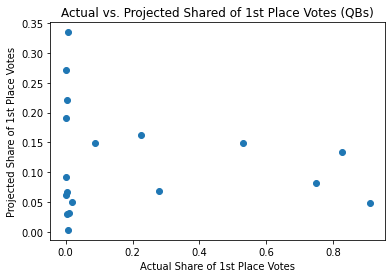

In [26]:
preds = mlp_qb.predict(Xqb_test)
plt.scatter(Yqb_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes (QBs)")
plt.savefig("../plots/nn_qb.jpg")

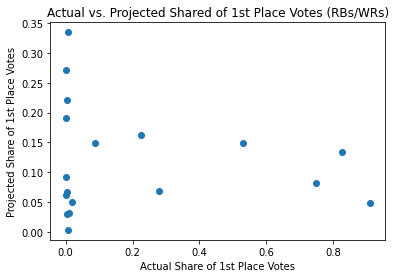

In [27]:
preds = mlp_qb.predict(Xqb_test)
plt.scatter(Yqb_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes (RBs/WRs)")
plt.savefig("../plots/nn_rbwr.jpg")

**Conclusion**

The R-squared values are not much better here. Negative R-squared means we could do better with a fixed guess for each candidate. Yikes.